# Rossmann Store Sales
### Forecast sales using store, promotion, and competitor data


Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
We are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column.

Data fields
* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
!pip install joblib==0.13.2
!pip install pandas==0.25.1
!pip install numpy==1.16.5
!pip install scikit_learn==0.24.1

  Using cached scikit_learn-0.24.1-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.8.1 requires joblib>=0.14, but you have joblib 0.13.2 which is incompatible.
kapre 0.3.5 requires numpy>=1.18.5, but you have numpy 1.16.5 which is incompatible.


In [ ]:
# importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## What our data looks like

In [ ]:
# This is the data which contains store details
store_details = pd.read_csv("https://s3.amazonaws.com/projex.dezyre.com/forecast-rossmann-store-sales/materials/store.csv")
store_details

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
# Our Train data
train_data = pd.read_csv("https://s3.amazonaws.com/projex.dezyre.com/forecast-rossmann-store-sales/materials/train.csv")
train_data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [ ]:
# merged our train data and store details data based on store number to get complete info for each store
combined_data = pd.merge(train_data, store_details, on='Store')
combined_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [ ]:
combined_data.shape

(1017209, 18)

## Exploring Dataset

In [ ]:
# missing values in the dataset
print("Total size of dataset: ", len(combined_data))
print(combined_data.isnull().sum())

Total size of dataset:  1017209
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


In [ ]:
# unique values in dataset
columns = list(combined_data.columns)
columns.remove('Date')
columns.remove('CompetitionDistance')
for col in columns:
    print(col,"-------->",combined_data[col].unique())

Store --------> [   1    2    3 ... 1113 1114 1115]
DayOfWeek --------> [5 4 3 2 1 7 6]
Sales --------> [ 5263  5020  4782 ... 20362 18841 21237]
Customers --------> [ 555  546  523 ... 3727 4022 4106]
Open --------> [1 0]
Promo --------> [1 0]
StateHoliday --------> ['0' 'a' 'b' 'c' 0]
SchoolHoliday --------> [1 0]
StoreType --------> ['c' 'a' 'd' 'b']
Assortment --------> ['a' 'c' 'b']
CompetitionOpenSinceMonth --------> [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
CompetitionOpenSinceYear --------> [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
Promo2 --------> [0 1]
Promo2SinceWeek --------> [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
Promo2SinceYear --------> [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
PromoInterval --------> [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


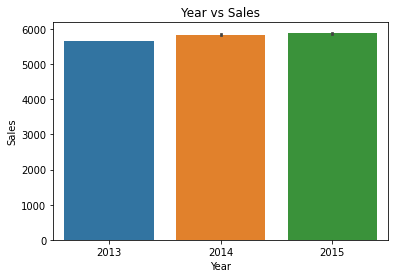

In [ ]:
# extracting year and month from Date 
combined_data['Year']  = combined_data['Date'].apply(lambda x: int(str(x)[:4]))
combined_data['Month'] = combined_data['Date'].apply(lambda x: int(str(x)[5:7]))

# Sales with respect to year 
sns.barplot(x='Year', y='Sales', data=combined_data).set(title='Year vs Sales')
plt.show()

##### Sales have been increasing year to year

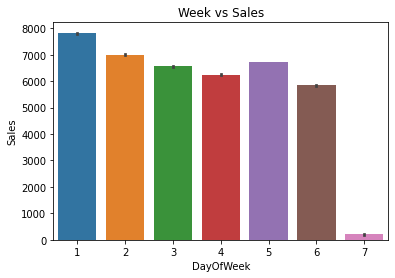

In [ ]:
# Sales with respect to week
sns.barplot(x='DayOfWeek', y='Sales', data=combined_data).set(title='Week vs Sales')
plt.show()

##### Sales on 1 (Monday) and 5 (Friday) are the highest

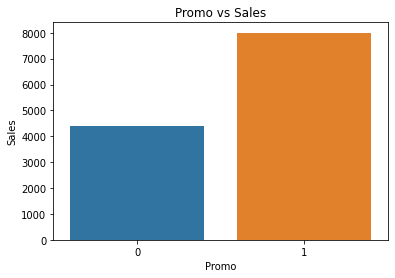

In [ ]:
# Sales with respect to Promo
sns.barplot(x='Promo', y='Sales', data=combined_data).set(title='Promo vs Sales')
plt.show()

##### Customers are definately attracted by Promo codes thus sales are higher when there is a Promo code in a Store

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


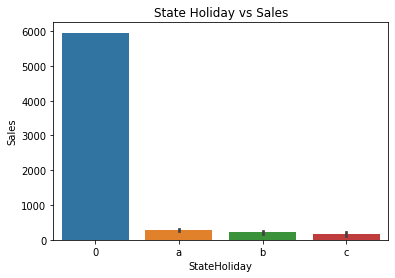

In [ ]:
# StateHoliday column has values 0 & "0", So, we need to change values with 0 to "0"
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == 0] = "0"

# Sales with respect to State Holiday
sns.barplot(x='StateHoliday', y='Sales', data=combined_data).set(title='State Holiday vs Sales')
plt.show()

##### Most stores are closed on State Holidays that's why we can see that there are very less sales in a,b,c where:
* a = Public Holiday
* b = Easter Holiday
* c = Chirstmas 
* 0 = No Holiday, Working day

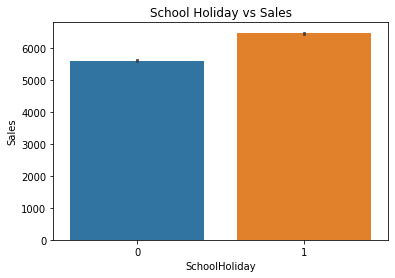

In [ ]:
# Sales with respect to School Holiday
sns.barplot(x='SchoolHoliday', y='Sales', data=combined_data).set(title='School Holiday vs Sales')
plt.show()

##### On School Holidays there are more sales!

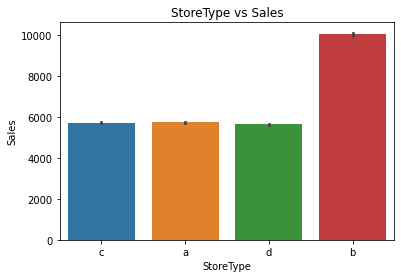

In [ ]:
# Sales with respect to StoreType
sns.barplot(x='StoreType', y='Sales', data=combined_data).set(title='StoreType vs Sales')
plt.show()

##### a,b,c,d are store models where b type stores have the highest sales 

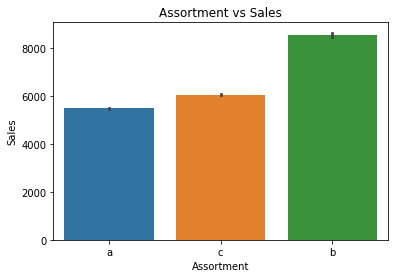

In [ ]:
# Sales with respect to Assortment
sns.barplot(x='Assortment', y='Sales', data=combined_data).set(title='Assortment vs Sales')
plt.show()

##### Assortment level b have the highest sales
##### Assortment levels:
* a = basic
* b = extra
* c = entended

## Filling Missing Values and Removing Outliers

Few columns have high number of missing values, so we need to fill them with appropriate method for better result

### Filling Missing Values
##### Approach
1: The null values in Column Promo2SinceWeek, Promo2SinceYear, PromoInterval is due to Promo2 is 0 for those stores. So we would fill all the null values in these columns with 0.

2: Since Competition Distance for 3 stores isn't given so we could fill it with mean of the distance given for all other stores

3: CompetitionOpenSinceMonth, CompetitionOpenSinceYear can be filled using the most occuring month and year respectively. 

In [ ]:
store_details.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
train_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [ ]:
# Filling Promo2SinceWeek, Promo2SinceYear, PromoInterval with 0
store_details.update(store_details[['Promo2SinceWeek','Promo2SinceYear','PromoInterval']].fillna(0))

In [ ]:
# Filling CompetitionDistance with mean distance
mean_competition_distance = store_details['CompetitionDistance'].mean()
store_details['CompetitionDistance'].fillna(mean_competition_distance, inplace=True)

In [ ]:
# Filling CompetitionOpenSinceMonth, CompetitionOpenSinceYear with most occuring month and year respectively
mode_competition_open_month = store_details['CompetitionOpenSinceMonth'].mode()[0]

mode_competition_open_year = store_details['CompetitionOpenSinceYear'].mode()[0]

store_details['CompetitionOpenSinceMonth'].fillna(mode_competition_open_month,inplace=True)
store_details['CompetitionOpenSinceYear'].fillna(mode_competition_open_year,inplace=True)

In [ ]:
store_details.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

* All missing values have been filled

In [ ]:
# merging the data again
combined_data = pd.merge(train_data, store_details, on='Store')
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [ ]:
combined_data.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

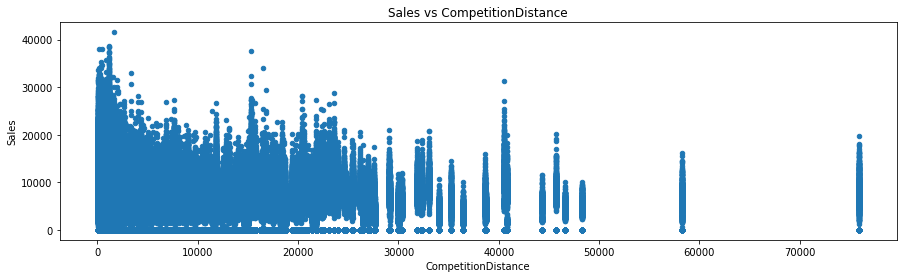

In [ ]:
combined_data.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4),title="Sales vs CompetitionDistance")

* CompetitionDistance is the distance in meters to the nearest competitor store, the more nearer the two stores are the more sales can be seen

### Finding Outliers

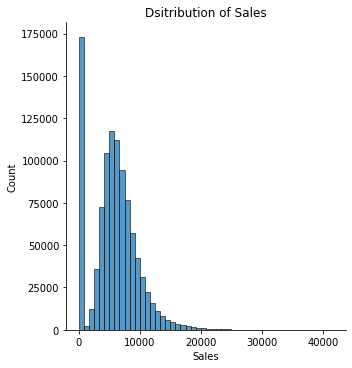

In [ ]:
# checking distribution of sales 
sns.displot(combined_data, x="Sales",bins=50).set(title='Dsitribution of Sales')

* As we can see in the distribution plot Sales greater than 30k are very less so they might be the outliers

### Z-Score: If the Z-Score of a datapoint is greater than 3 that can be considered as an Outlier

Mean of Sales:  5773.818972305593
Standard Deviation of Sales:  3849.9242828437527
Total outlier in dataset are:  9731
Maximum Sales Outlier:  41551
Minimum Sales Outlier:  17325


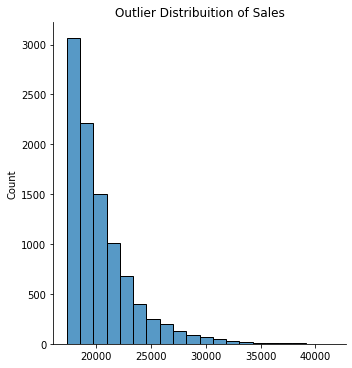

In [ ]:
mean_of_sales = np.mean(combined_data['Sales']) 
std_of_sales = np.std(combined_data['Sales'])
print("Mean of Sales: ",mean_of_sales)
print("Standard Deviation of Sales: ",std_of_sales)

threshold = 3
outlier = [] 
for i in combined_data['Sales']: 
    z = (i-mean_of_sales)/std_of_sales
    if z > threshold: 
        outlier.append(i) 
print('Total outlier in dataset are: ', len(outlier))
print("Maximum Sales Outlier: ", max(outlier))
print("Minimum Sales Outlier: ", min(outlier))

sns.displot(x=outlier,bins=20).set(title='Outlier Distribuition of Sales')

In [ ]:
# Looking for outliers
sales_zero = combined_data.loc[combined_data['Sales'] == 0] 
sales_greater_than_30 = combined_data.loc[combined_data['Sales'] > 30000]

print("Length of actual dataset:", len(combined_data))
print("Length of data where sales is 0:", len(sales_zero),
      " which is", len(sales_zero)/len(combined_data)*100, "% of the whole data", )

print("Length of data which is greater than 30:", len(sales_greater_than_30),
      "which is ", len(sales_greater_than_30)/len(combined_data)*100, "% of the whole data")

Length of actual dataset: 1017209
Length of data where sales is 0: 172871  which is 16.994639253093514 % of the whole data
Length of data which is greater than 30: 153 which is  0.015041156733768577 % of the whole data


* Droping sales which are greater than 30k as they are very less in the dataset and are probably outliers

In [ ]:
combined_data.drop(combined_data.loc[combined_data['Sales'] > 30000].index,inplace=True)
combined_data.shape

(1017056, 18)

## Further EDA - exploring exceptional cases
Looking for a scenerio where the Stores are open and yet there is no sales on that day

In [ ]:
# no sales when Stores were Open
no_holiday_zero_sales = combined_data.loc[(combined_data['Sales'] == 0) & (combined_data['Open'] == 1) & 
                                          (combined_data['StateHoliday'] == 0) & (combined_data['SchoolHoliday'] == 0)]

print("Size of the data where sales were zero even when stores were open: ",len(no_holiday_zero_sales))
no_holiday_zero_sales.head()

Size of the data where sales were zero even when stores were open:  12


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
22589,25,4,2014-02-13,0,0,1,0,0,0,c,a,430.0,4.0,2003.0,0,0.0,0.0,0
22590,25,3,2014-02-12,0,0,1,0,0,0,c,a,430.0,4.0,2003.0,0,0.0,0.0,0
25212,28,4,2014-09-04,0,0,1,1,0,0,a,a,1200.0,10.0,2014.0,1,6.0,2015.0,"Mar,Jun,Sept,Dec"
205303,227,4,2014-09-11,0,0,1,0,0,0,a,a,2370.0,9.0,2013.0,0,0.0,0.0,0
297110,327,3,2014-03-12,0,0,1,0,0,0,c,c,1390.0,12.0,2004.0,0,0.0,0.0,0


* Removing these data points too as they are an exceptional case

In [ ]:
combined_data.drop(combined_data.loc[(combined_data['Sales'] == 0) & (combined_data['Open'] == 1) & 
                                     (combined_data['StateHoliday'] == 0) & 
                                     (combined_data['SchoolHoliday'] == 0)].index,inplace=True)
combined_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [ ]:
combined_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


## Converting Categorical Variable to Numeric

In [ ]:
# extracting year and month from Date 
combined_data['Year']  = combined_data['Date'].apply(lambda x: int(str(x)[:4]))
combined_data['Month'] = combined_data['Date'].apply(lambda x: int(str(x)[5:7]))
combined_data.drop(['Date'],axis=1,inplace=True)

In [ ]:
combined_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
0,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
1,1,4,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
2,1,3,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
3,1,2,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
4,1,1,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7


In [ ]:
# encoding all categorical varibale to numeric values
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()

combined_data['StoreType']= label_encoder.fit_transform(combined_data['StoreType'])
combined_data['Assortment']= label_encoder.fit_transform(combined_data['Assortment']) 

# for promo interval
combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Jan,Apr,Jul,Oct"] = 1
combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Feb,May,Aug,Nov"] = 2
combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Mar,Jun,Sept,Dec"] = 3
'''
new_promo_interval = []
for i in range(len(combined_data)):
    if combined_data['PromoInterval'][i] == 'Jan,Apr,Jul,Oct':
        new_promo_interval.append(1)
    elif combined_data['PromoInterval'][i] == 'Feb,May,Aug,Nov':
        new_promo_interval.append(2)
    elif combined_data['PromoInterval'][i] == 'Mar,Jun,Sept,Dec':
        new_promo_interval.append(3)
    else:
        new_promo_interval.append(0)
        
combined_data['PromoInterval'] = new_promo_interval        
'''

# for State Holiday
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == "a"] = 1
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == "b"] = 2
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == "c"] = 3

'''
state_holiday_list = []
for i in range(len(combined_data)):
    if combined_data['StateHoliday'][i] == 'a':
        state_holiday_list.append(1)
    elif combined_data['StateHoliday'][i] == 'b':
        state_holiday_list.append(2)
    elif combined_data['StateHoliday'][i] == 'c':
        state_holiday_list.append(3)
    else:
        state_holiday_list.append(0)


combined_data['StateHoliday'] = state_holiday_list
'''
combined_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
0,1,5,5263,555,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
1,1,4,5020,546,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
2,1,3,4782,523,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
3,1,2,5011,560,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
4,1,1,6102,612,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7


In [ ]:
combined_data['StateHoliday'] = pd.to_numeric(combined_data['StateHoliday'])
combined_data['PromoInterval'] = pd.to_numeric(combined_data['PromoInterval'])

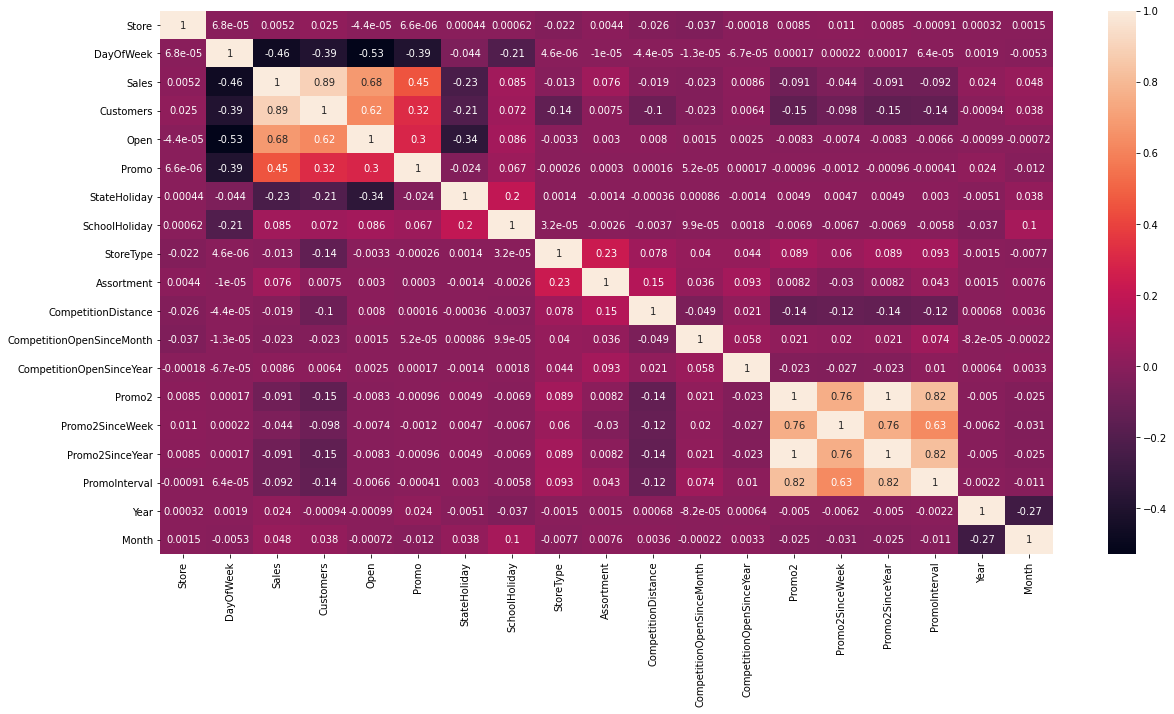

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(combined_data.corr(),annot=True)

##### Correlation map shows
* Sales is highly correlated with Customers, Open, Promo code
* Promo code is highly correlated to Promo2SinceWeek, Promo2SinceYear, PromoInterval

## Implementing Models

In [ ]:

combined_data[combined_data['Open']==0]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month
5,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
12,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
19,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
26,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
33,1,7,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017182,1115,7,0,0,0,0,0,0,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1
1017189,1115,7,0,0,0,0,0,0,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1
1017196,1115,7,0,0,0,0,0,0,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1
1017203,1115,7,0,0,0,0,0,1,3,2,5350.0,9.0,2013.0,1,22.0,2012.0,3,2013,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math  

In [ ]:
combined_data_subset = combined_data[combined_data['Open'] == 1]
combined_data_subset_closed = combined_data[combined_data['Open'] == 0]
x_train, x_test, y_train, y_test_open = train_test_split(combined_data_subset.drop(['Sales','Customers', 'Open'],axis=1),
                                                    combined_data_subset['Sales'],test_size=0.20)

In [ ]:
epsilon = 1e-10

In [ ]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month'],
      dtype='object')

## Linear Regression

In [ ]:
from sklearn import linear_model

reg_model = linear_model.LinearRegression() # making regression model
reg_model.fit(x_train, y_train) 

prediction_open = reg_model.predict(x_test)

prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))

r2_score:  0.7729577949918232
Mean absolute error: 999.44
Root mean squared error:  1953.2104071073438


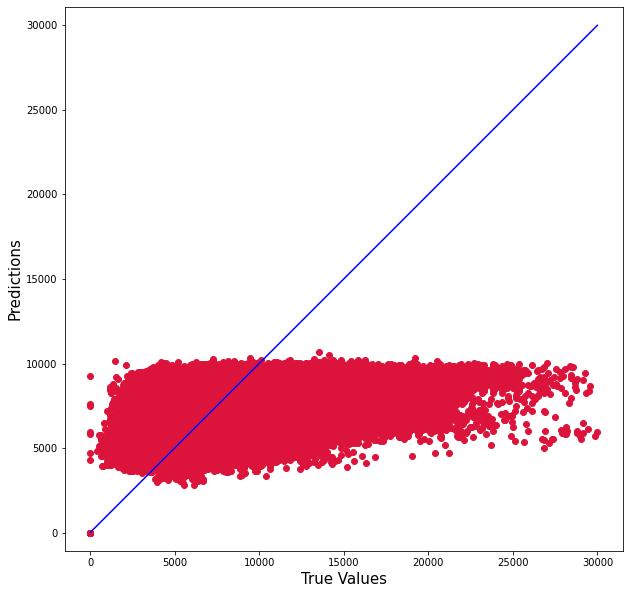

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## SGD Regressor
Stochastic Gradient Descent (SGD) is a simple yet efficient optimization algorithm used to find the values of parameters/coefficients of functions that minimize a cost function. 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1223: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


r2_score:  -4.2443718452794836e+23
Mean absolute error: 1194840175170342.50
Root mean squared error:  2670560641752085.0


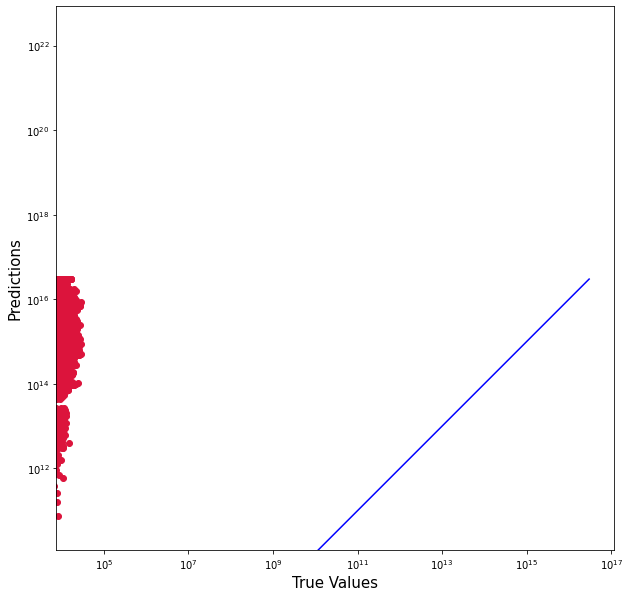

In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_regressor_model = SGDRegressor(max_iter=2)  # increasing this value leads to over fitting
sgd_regressor_model.fit(x_train,y_train)

prediction_open = sgd_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))

plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Random Forest Regressor

r2_score:  0.9656202477059873
Mean absolute error: 356.88
Root mean squared error:  760.0586453420348


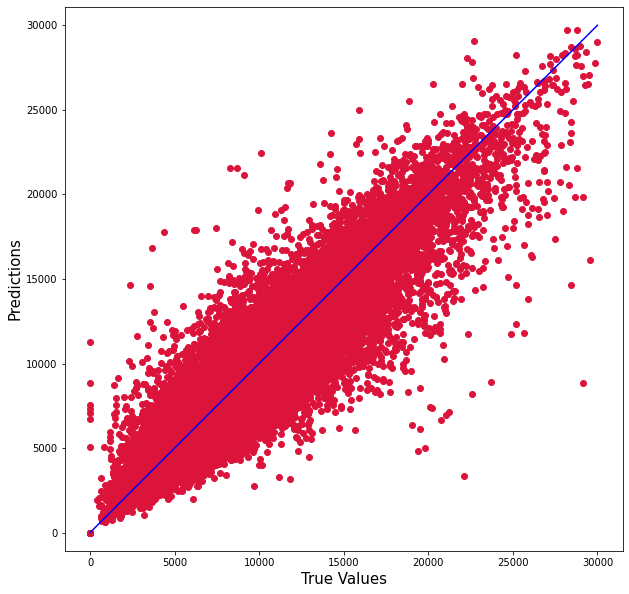

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor_model = RandomForestRegressor()
random_forest_regressor_model.fit(x_train,y_train)

prediction_open = random_forest_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))


plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Decision Tree Regressor

r2_score:  0.9520448755424252
Mean absolute error: 420.55
Root mean squared error:  897.6628307919268


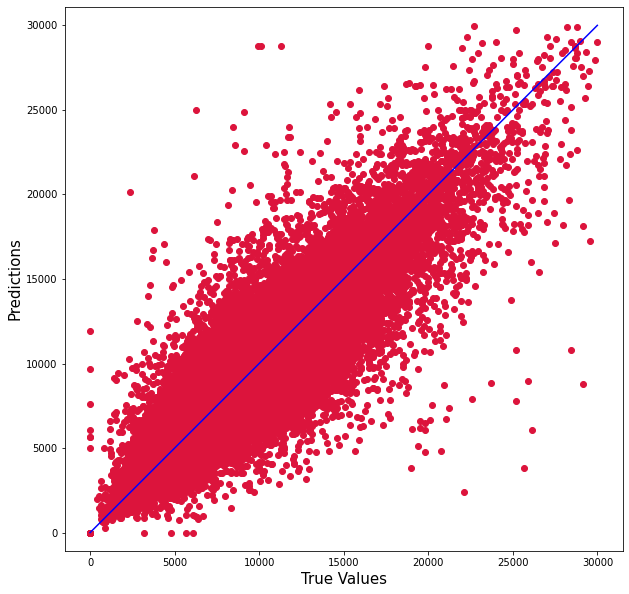

In [ ]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_regressor_model = DecisionTreeRegressor()
decision_tree_regressor_model.fit(x_train,y_train)

prediction_open = decision_tree_regressor_model.predict(x_test)
prediction_closed = np.zeros(combined_data_subset_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(combined_data_subset_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))


plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Random Forest Regressor had the lowest error as compared to other stores that means it is better at predicting sales than other models so we have selected that as our model

## Understanding the important features


In [ ]:
# getting weights of all the features used in the data
feature_importance = random_forest_regressor_model.feature_importances_
feature_importance

array([0.18127806, 0.08135063, 0.140497  , 0.00124205, 0.01260186,
       0.03443415, 0.03100452, 0.20795121, 0.0691673 , 0.07476756,
       0.00339405, 0.02942487, 0.03273903, 0.01304367, 0.02388011,
       0.06322392])

In [ ]:
# features used
columns = list(x_train.columns)
columns

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'Year',
 'Month']

In [ ]:
feature_importance_value = []
for i in range(len(feature_importance)):
    feature_importance_value.append(round(feature_importance[i],5))
feature_importance_value

[0.18128,
 0.08135,
 0.1405,
 0.00124,
 0.0126,
 0.03443,
 0.031,
 0.20795,
 0.06917,
 0.07477,
 0.00339,
 0.02942,
 0.03274,
 0.01304,
 0.02388,
 0.06322]

In [ ]:
# making a dataframe
feature_importance_df = pd.DataFrame({"Features":columns,
                                     "Values":feature_importance_value })
feature_importance_df

,Features,Values
0,Store,0.18128
1,DayOfWeek,0.08135
2,Promo,0.14050
3,StateHoliday,0.00124
4,SchoolHoliday,0.01260
5,StoreType,0.03443
6,Assortment,0.03100
7,CompetitionDistance,0.20795
8,CompetitionOpenSinceMonth,0.06917
9,CompetitionOpenSinceYear,0.07477


In [ ]:
feature_importance_df.sort_values(by=["Values"], inplace=True, ascending=False)
feature_importance_df

,Features,Values
7,CompetitionDistance,0.20795
0,Store,0.18128
2,Promo,0.14050
1,DayOfWeek,0.08135
9,CompetitionOpenSinceYear,0.07477
8,CompetitionOpenSinceMonth,0.06917
15,Month,0.06322
5,StoreType,0.03443
12,Promo2SinceYear,0.03274
6,Assortment,0.03100


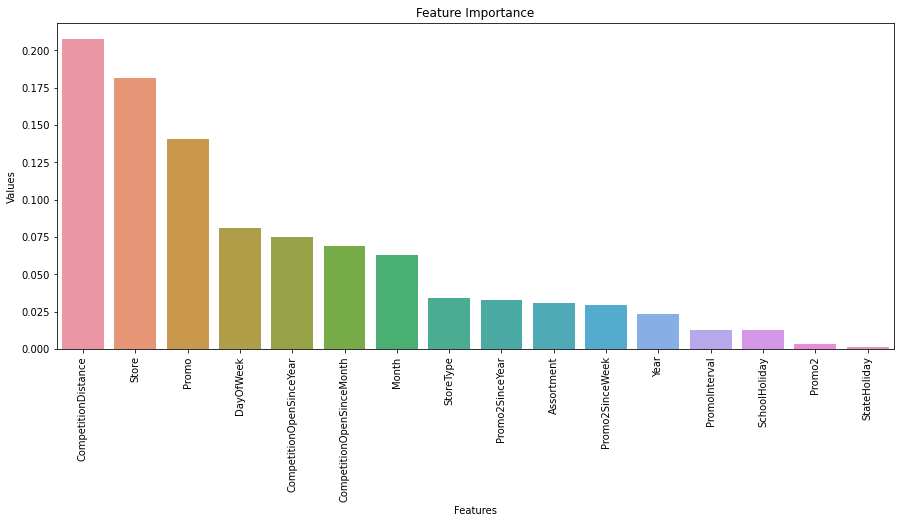

In [ ]:
# Feature Importance
plt.figure(figsize=(15,6))

sns.barplot(x=feature_importance_df['Features'], y=feature_importance_df['Values'],
            data = feature_importance_df ).set(title='Feature Importance')

plt.xticks(rotation=90)
plt.show()

## Conclusion
* Feature engineering is very important. e.g. removal of the 'Open'. feature
* Closer competiton distance make stores more competitive and thus using Promo codes can help them to boost sales 
* Store Type affects the sales
* Promo code can help increase in the competition and lead to more sales
* Since most of the stores are closed on Holidays, the feature has no effect on sales